In [11]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.transform import resize
from sklearn.model_selection import train_test_split
import autosklearn.regression
import sklearn


In [12]:
# helper functions
def plot_images(images, velocity, rows, cols, title = ''):
    total_images = len(images)
    if total_images > rows * cols:
        print("Warning: More images than subplot cells. Some images may not be displayed.")

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))

    for i in range(rows):
        for j in range(cols):
            index = i * cols + j
            if index < total_images:
                img = images[index]
                im = axes[i, j].imshow(img, cmap='seismic')
                axes[i, j].axis('off')
                avg_velocity = velocity[index]
                t = f"Avg velocity {avg_velocity:.2f}"
                axes[i, j].set_title(t)
                cbar = fig.colorbar(im, ax=axes[i, j], orientation='vertical', fraction=0.03, pad=0.05)

    plt.suptitle(title, fontsize=16)
    plt.show()


def downsample_images_interpolation(images, output_shape):

    num_images = images.shape[0]
    downsampled_images = np.zeros((num_images, *output_shape), dtype=images.dtype)

    for i in range(num_images):
        downsampled_images[i] = resize(images[i], output_shape, anti_aliasing=True)

    return downsampled_images

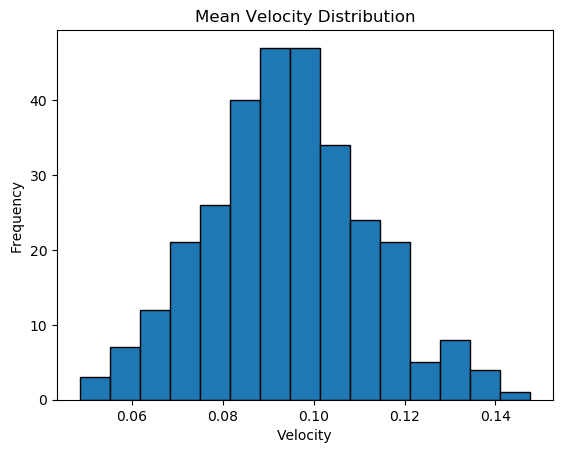

Number of training samples:  240
Number of test samples:  60
Minimum and maximum values of X_train: 4.748478146272038e-09  -  0.05238646865396034
Minimum and maximum values of X_test: 7.031539088997217e-09  -  0.050612983860742554
Minimum and maximum values of Y_train: 4.748478146272038e-09  -  0.1477140937412357
Minimum and maximum values of Y_test: 7.031539088997217e-09  -  0.13472594575015961


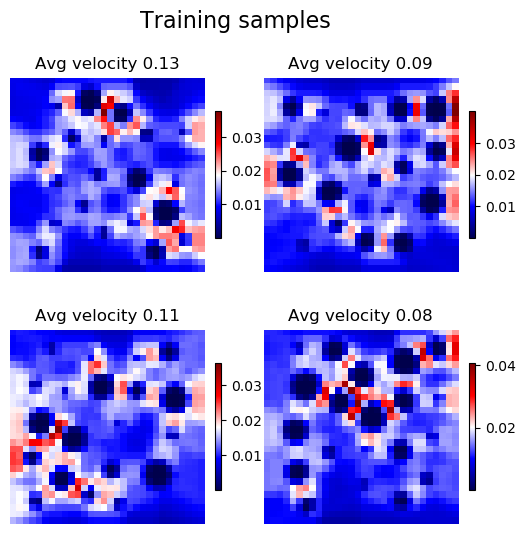

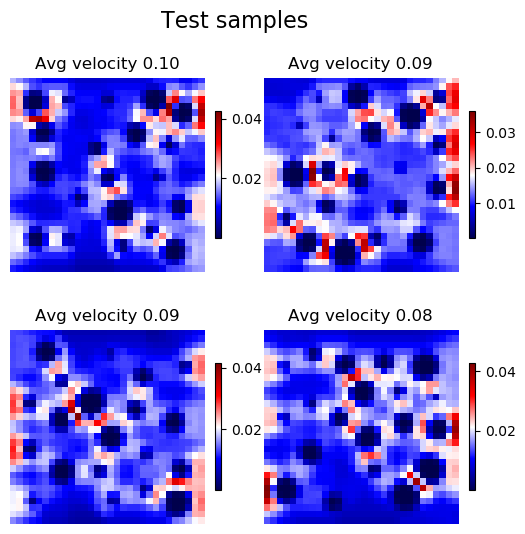

In [13]:
# Load Data
"""
# This part of the code is used only once to load data from txt files and save as npy file
# so that future loading is faster
directory = "../HPO/domain_generation"
input_images = np.zeros((300, 500, 500))
output_images = np.zeros((300, 500, 500))
for i in range(300):
    file_kn = directory + "/d" + str(i+1) + "/Kn.txt"
    file_ux = directory + "/d" + str(i+1) + "/out/UX.txt"
    kn = np.loadtxt(file_kn)
    ux = np.loadtxt(file_ux)
    kn = kn.reshape((500, 500))
    ux = ux.reshape((500, 500))
    input_images[i, :, :] = kn
    output_images[i, :, :] = ux
    print(i)

np.save('input', input_images)
np.save('output', output_images)
"""

X = np.load("../dataset/input.npy")
Y = np.load("../dataset/output.npy")
velocity = np.zeros(Y.shape[0])

# Average velocities
for i in range(Y.shape[0]):
    sample = Y[i]
    velocity[i] = np.mean(sample)

# plot velocity histogram
plt.figure()
plt.hist(velocity, bins=15, edgecolor='black')
plt.xlabel("Velocity")
plt.ylabel("Frequency")
plt.title("Mean Velocity Distribution")
plt.show()

# downsample
output_shape = (30, 30)
X = downsample_images_interpolation(X, output_shape)

# split, using mean velocity as target value
X_train, X_test, Y_train, Y_test = train_test_split(X, velocity, test_size=0.2, shuffle=True, random_state=100)

print("Number of training samples: ", X_train.shape[0])
print("Number of test samples: ", X_test.shape[0])

print("Minimum and maximum values of X_train:", np.min(X_train), " - ", np.max(X_train))
print("Minimum and maximum values of X_test:", np.min(X_test), " - ", np.max(X_test))

print("Minimum and maximum values of Y_train:", np.min(X_train), " - ", np.max(Y_train))
print("Minimum and maximum values of Y_test:", np.min(X_test), " - ", np.max(Y_test))

plot_images(X_train[0:4], Y_train[0:4], rows=2, cols=2, title = 'Training samples')
plot_images(X_test[0:4], Y_test[0:4], rows=2, cols=2, title = 'Test samples')




In [14]:
# Linearize Images
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)


In [15]:
automl = autosklearn.regression.AutoSklearnRegressor(time_left_for_this_task=3600,
            resampling_strategy="cv", resampling_strategy_arguments={"train_size": 0.8,  "shuffle": True,  "folds": 5})

automl.fit(X_train, Y_train)


AutoSklearnRegressor(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                     per_run_time_limit=360, resampling_strategy='cv',
                     resampling_strategy_arguments={'folds': 5, 'shuffle': True,
                                                    'train_size': 0.8})

In [19]:
# show configuration
automl.show_models()
run_key = list(automl.automl_.runhistory_.data.keys())[0]
print(automl.automl_.runhistory_.ids_config[run_key.config_id])

Configuration(values={
  'data_preprocessor:__choice__': 'feature_type',
  'data_preprocessor:feature_type:numerical_transformer:imputation:strategy': 'mean',
  'data_preprocessor:feature_type:numerical_transformer:rescaling:__choice__': 'standardize',
  'feature_preprocessor:__choice__': 'no_preprocessing',
  'regressor:__choice__': 'random_forest',
  'regressor:random_forest:bootstrap': 'True',
  'regressor:random_forest:criterion': 'mse',
  'regressor:random_forest:max_depth': 'None',
  'regressor:random_forest:max_features': 1.0,
  'regressor:random_forest:max_leaf_nodes': 'None',
  'regressor:random_forest:min_impurity_decrease': 0.0,
  'regressor:random_forest:min_samples_leaf': 1,
  'regressor:random_forest:min_samples_split': 2,
  'regressor:random_forest:min_weight_fraction_leaf': 0.0,
})



          rank  ensemble_weight               type      cost    duration
model_id                                                                
115          1             0.42                sgd  0.631327    9.028147
41           2             0.08  gradient_boosting  0.710852   11.294420
45           3             0.20     ard_regression  0.762296    2.474422
66           4             0.20                sgd  0.795052    2.089682
111          5             0.08   gaussian_process  0.966247  211.957367
31           6             0.02           adaboost  1.047900    6.617460
Train R2 score: 0.8128703303555141
Test R2 score: 0.5895959904574638


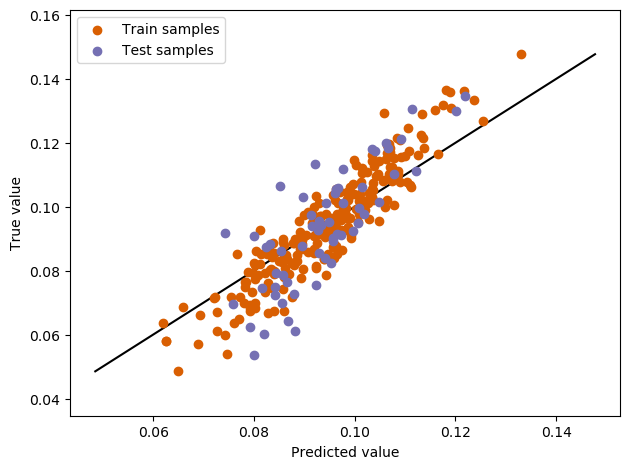

In [20]:
print(automl.leaderboard())
train_predictions = automl.predict(X_train)
print("Train R2 score:", sklearn.metrics.r2_score(Y_train, train_predictions))
test_predictions = automl.predict(X_test)
print("Test R2 score:", sklearn.metrics.r2_score(Y_test, test_predictions))

plt.scatter(train_predictions, Y_train, label="Train samples", c="#d95f02")
plt.scatter(test_predictions, Y_test, label="Test samples", c="#7570b3")
plt.xlabel("Predicted value")
plt.ylabel("True value")
plt.legend()
plt.plot([ min(velocity), max(velocity)], [min(velocity), max(velocity)], c="k", zorder=0)

plt.tight_layout()
plt.show()